# Big Data and Finding the "needle in the haystack" galaxies
*A python excersie notebook written by Lewis McMillan, Summer 2020. This notebook has benifited from examples provided by Rita Tojeiro, and the help of Anne-Marie Weijmans, and Simon Reynolds.*

In this notebook you will use data from the Sloan Digital Sky Survey (SDSS), to explore how astronomers interact with "big data", and how they can use various different measurments of galaxies shapes in order to find spiral galaxies, the mergering of multiple galaxies, and other interesting galaxies.

## SDSS and SciServer

As mentioned above, in this notebook we will use data from SDSS, which is is the largest astronmical dataset in the world currently. For eachs nights observing it generates around 200Gb of data. The laptop this notebook was written on has 256Gb of storage space, meaning that I could fit 1 nights observing data on my laptop with some space left over for all the programs I need to analysie the data.

If you are reading this then we assume that you havel alredy followed the instructions to get an account on SciServer, and have uploaded this notebook. In addition to this we assume that you are familiar with basic python, dataframe manipulation, and matplotlib commands. If not please complete Rita Tojeiro's notebook's which cover these topics: link here

### Imports
To get started we first install and then import all the libraries we will need in this notebook

In [15]:
#install python libraries that are needed
#!pip install dataclasses                           # needed as Python is a lower version than code needs
#!pip install astropy                               # general purpose astronomy library
#!pip install photutils                             # photomertry general purpose library
#!pip install scikit-image                          # image anaylsis genral purpose library
#!pip install tqdm                                  # pretty progress bar

import pawlikMorphLSST as pmlsst                    # Library for analysing galaxies
print("Galaxy analysis code imported")

# Import Python libraries to work with SciServer
import SciServer.CasJobs as CasJobs                 # query with CasJobs
print('SciServer libraries imported')

# Import other libraries for use in this notebook.
import numpy as np                                  # standard Python lib for math ops
import pandas as pd                                 # data manipulation package
import matplotlib.pyplot as plt                     # another graphing package
from pathlib import Path                            # manage local files in your Compute containers
from astropy.visualization import ZScaleInterval    # for plotting clear images
from tqdm import tqdm_notebook                      # for a nice progress bar
from concurrent.futures import ProcessPoolExecutor  # for running the code on more than 1 cpu
from IPython.display import clear_output            # allow nice printing
print('Supporting libraries imported')

# Apply some special settings to the imported libraries
# ensure columns get written completely in notebook
pd.set_option('display.max_colwidth', -1)

# for plotting clear images
zscale = ZScaleInterval()

# do *not* show python warnings 
import warnings
warnings.filterwarnings('ignore')
print('Settings applied')

Galaxy analysis code imported
SciServer libraries imported
Supporting libraries imported
Settings applied


## Querying the SDSS database

The SDSS data is stored in a SQL database. Databases can be thought of as large tables of information. SQL is  one language that can be used to communicate with databases via "queries". For each query command, the database returns an answer. Usually, this is a subsample of the original database, though SQL can operate on the data very effectively too. In this tutorial we will submit queries to the SDSS database to gather the information that we need, and we will use Python to operate on, manipulate, and vizualise that data.

An extensive tutorial on how to query the SDSS database is provided here: http://skyserver.sdss.org/dr16/en/help/howto/search/searchhowtohome.aspx . In short, nearly every SQL command consists of three blocks:

The SELECT block: it defines the quantities that you want your query to return.
The FROM block: it defines which tables of the database you want SQL to look in.
The WHERE block: it defines any constraints on the data that you want to impose.
In this Lab you won't have to write SQL queries from scratch, only execute commands that are already written for you.

Using SQL and SciServer to return galaxy data
For the database schema and documentation see http://skyserver.sdss.org/dr16/en/help/browser/browser.aspx The following query returns specific information on a sample of galaxies, as a Pandas dataframe.


In [3]:
# Find objects in the Sloan Digital Sky Survey's.
#
# Query the Sloan Digital Sky Serveys' NSA catalog of galactical objects.
# For the database schema and documentation see http://skyserver.sdss.org/dr16/en/help/browser/browser.aspx?cmd=description+nsatlas+U#&&history=description+nsatlas+U
#
# This query finds all galaxies in the value added catalogue PawlikMorph and matches this information to the
# MaNGA catalogue in order to get galaxies positions.
# Finally we discard any galaxies that have incomplete measurments
#
# First, store the query in an object called "query"
query="""
select distinct m.objra, m.objdec, p.A, p.[As], p.As90, p.S, p.G, p.C2080, p.C5090, p.M20, p.run, p.rerun, p.camcol, p.field
from dbo.PawlikMorph p
  join dbo.mangaDAPall m
  on m.mangaID = p.mangaid and m.plateifu = p.plateifu
  """
#where p.warningflag = 0 and p.A > -99 and p.S > -99 and p.C2080 > -99 and p.C5090 > -99
#"""

#Then, query the database. The answer is a table that is being returned to a dataframe that we've named all_gals.
all_gals = CasJobs.executeQuery(query, "dr16")

print("SQL query finished.")
print(f"SQL query returned {len(all_gals.index)} galaxies")

SQL query finished.
SQL query returned 4603 galaxies


The dataframe that is returned, named all_gals, holds the following quantities for each galaxy:
 * objra, objdec = The position of the galaxy. RA is the Right Ascension coordinate in degress, and DEC is the Declination corordiante in degrees
 * A = the asymmetry
 * As = the shape asymmetry at 180 degrees
 * As90 = the shape asymetry at 90 degrees
 * S = Smoothness parameter
 * G = Gini index
 * C2080, C5090 = The concentraion of light within a certain annulus
 * M20 = The 2nd moment of light
 * run, rerun, camccol, field = information about which part of the camera took the image
 
Lets look at what all this data looks like, but first lets add a new column to the dataframe which contains the path to the image on SciServer. This will be useful later in the notebook.
To do this we need the information about which part of the camera took the image.

In [13]:
# add a column to the dataframe, which contains the path to the image
def makename(df):
    root = "/home/idies/workspace/sdss_das/das2/imaging/"
    df["fname"] = df.apply(lambda row: root + f"{row.run}/{row.rerun}/corr/{row.camcol}/fpC-{row.run:06}-r{row.camcol}-{row.field:04}.fit.gz", axis=1)
    return df

# add filename column
all_gals = makename(all_gals)
# View the information of the first 10 galaxies retrieved
all_gals[0:10]

,objra,objdec,A,As,As90,S,G,C2080,C5090,M20,run,rerun,camcol,field,fname
0,27.475456,13.126633,-0.022468,0.149598,0.155957,0.049302,0.551373,3.09359,1.88380,-2.031580,1035,40,2,144,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0144.fit.gz
1,27.529863,13.110374,0.043261,0.138830,0.173077,0.096871,0.653915,3.32362,2.13837,-2.078290,1035,40,2,144,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0144.fit.gz
2,27.565306,13.140773,0.060645,0.171206,0.194553,0.115196,0.592129,2.94275,1.94163,-1.819910,1035,40,2,144,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0144.fit.gz
3,27.653662,13.110200,0.165430,-99.000000,-99.000000,0.155478,0.826167,7.45512,5.86891,-0.568051,1035,40,2,145,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0145.fit.gz
4,27.842783,13.060335,0.204199,-99.000000,-99.000000,0.172169,0.849354,7.14371,5.69862,-0.552881,1035,40,2,146,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0146.fit.gz
5,27.886442,12.699600,0.010838,0.150585,0.690546,0.281075,0.456304,3.34295,2.06500,-1.765870,1035,40,1,147,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/1/fpC-001035-r1-0147.fit.gz
6,28.079226,13.634056,0.051562,0.170410,0.355398,0.070220,0.542558,3.69002,2.13114,-0.907639,1035,40,3,147,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/3/fpC-001035-r3-0147.fit.gz
7,28.185047,13.192551,0.030504,0.098608,0.207012,0.089205,0.650681,3.05745,1.91781,-2.076980,1035,40,2,148,/home/idies/workspace/sdss_das/das2/imaging/1035/40/corr/2/fpC-001035-r2-0148.fit.gz
8,28.375704,14.570949,0.043704,0.165480,0.434473,-99.000000,0.491647,3.35654,1.75424,-2.085590,1043,40,5,185,/home/idies/workspace/sdss_das/das2/imaging/1043/40/corr/5/fpC-001043-r5-0185.fit.gz
9,28.443092,12.880449,0.079273,0.182746,0.226987,0.131965,0.628332,4.12512,2.52833,-1.914470,1043,40,1,186,/home/idies/workspace/sdss_das/das2/imaging/1043/40/corr/1/fpC-001043-r1-0186.fit.gz


## Exercise:
 1. Plot the positions off all the galaxies using plt.scatter. Add appropriate labels and a title to your plot. As there is a large number of galaxies to plot you may want to use marker=".", and s="1".
 2. Can you explain why the distibution of galaxies is as shown? You may want to read https://blog.sdss.org/2015/06/11/how-sdss-used-light-to-make-the-largest-ever-image-of-the-night-sky/

Text(0.5, 1.0, 'Galaxy positions')

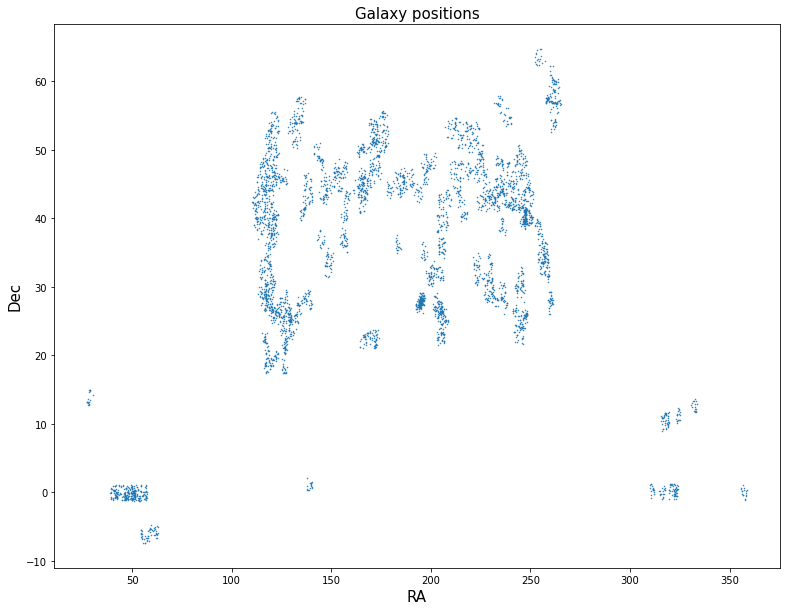

In [18]:
#possible solutions
#1.
plt.figure(figsize=(13,10))
plt.scatter(all_gals["objra"], all_gals["objdec"], s=1, marker=".")
plt.xlabel('RA', fontsize=15); plt.ylabel('Dec', fontsize=15)
plt.title('Galaxy positions', fontsize=15)
# 2. Would expect some anser along the lines that SDSS observes in stripes which gives the spider legs,
# and that galaxies are not uniformly distibuted not 

## Exercise:
    1. Classify each image into its morphological type, i.e spiral, elliptical, ring or other

Read image 16 of 16
Plotting images...


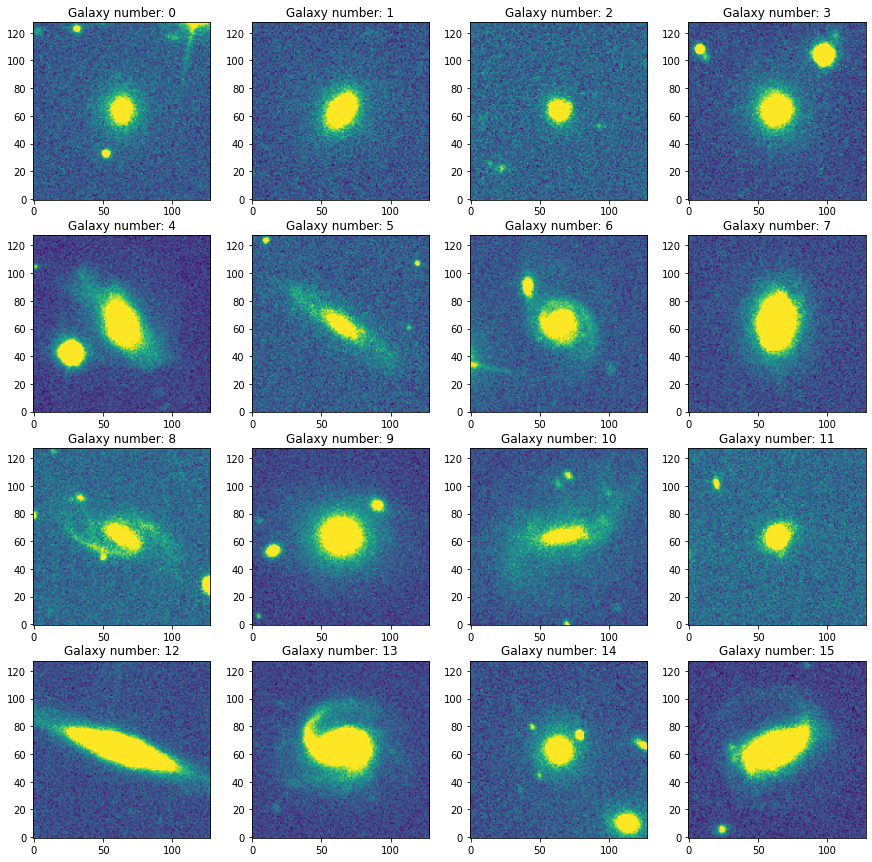

In [18]:
# display some galaxies in a 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(15, 15))

axs = axs.ravel()
i = 0
idx = 0
while True:
    clear_output(wait=True)
    print(f"Read image {i+1} of 16")
    filename = all_gals["fname"].iloc[idx]
    ra, dec = all_gals["objra"].iloc[idx], all_gals["objdec"].iloc[idx]
    # avoid any images that are on edge of image, so that we don't lose any light in calculations
    try:
       # read in image and crop to area of interest
        img = pmlsst.image.readImage("sdss", filename, ra, dec)
    except:
        idx += 1
        continue
    vmin, vmax = zscale.get_limits(img)
    axs[i].imshow(img, vmin=vmin, vmax=vmax, origin="lower")
    axs[i].set_title(f"Galaxy number: {idx}")
    if i == 15:
        break
    i += 1
    idx += 1
print("Plotting images...")

## Show how to process one image before moving onto "big data"
Take your favoutite galaxy number from the plots above and use it in the following section.

In [19]:
fav_galaxy = all_gals.iloc[13]
filename = fav_galaxy["fname"]
ra, dec = fav_galaxy["objra"], fav_galaxy["objdec"]
# read in image and crop to area of interest
img = pmlsst.image.readImage("sdss", filename, ra, dec)

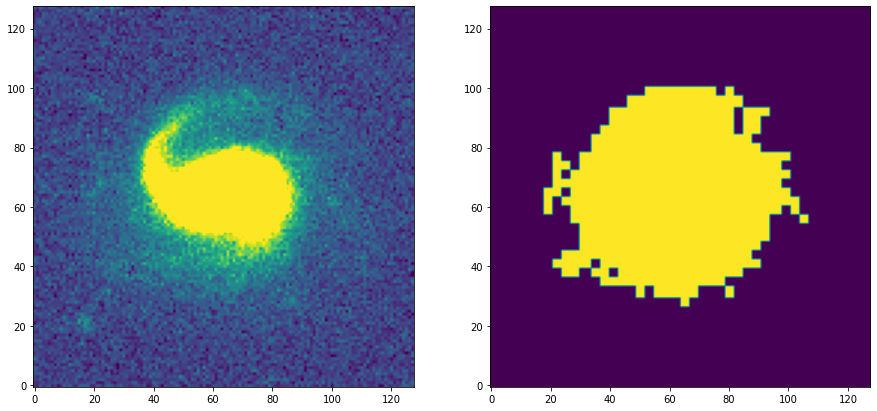

In [20]:
#preprocess favoutite image
img = pmlsst.imageutils.maskstarsSEG(img)
#estimate skybackground
skybgr, skybgr_err, *_ = pmlsst.skyBackground.skybgr(img)
# create image where the only bright pixels are the pixels that belong to the galaxy
mask = pmlsst.pixmap.pixelmap(img, skybgr + skybgr_err, 3)
# plot the cleaned image and the mask
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs = axs.ravel()
axs[1].imshow(mask, origin="lower")
axs[0].imshow(img, vmin=vmin, vmax=vmax, origin="lower")

In [ ]:
# Calculate asymmetries
A, As, As90 = pmlsst.asymmetry.calculateAsymmetries(img, mask)

In [ ]:
print(f"A: {A:0.3f}\nAs: {As:.3f}\nAs90: {As90:.3f}")

In [ ]:
# Calculate CASGM parameters
C, S, gini, m20 = pmlsst.casgm.calculateCSGM(img, mask, skybgr)

In [ ]:
print(f"C: {C:.03f}\nGini: {gini:.03f}\nS: {S:.03f}\nm20: {m20:.03f}")

## Processing big data

In [ ]:
# Using "single" CPU
results = []
for info in tqdm_notebook(filenames[:100]):
    results.append(analyseImage(info))

In [ ]:
results = []
with ProcessPoolExecutor(max_workers=4) as pool:
    for result in tqdm_notebook(pool.map(pmlsst.helpers.analyseImage, filenames[:100]), total=len(filenames)):
         results.append(result)

In [ ]:
# process results
finalResults = {"A": [], "As": [], "As90": [], "C": [], "S": [], "g": [], "m20": [], "fname": [], "radec": []}
for result in results:
    if result[0] != -99:
        finalResults["A"].append(result[0])
        finalResults["As"].append(result[1])
        finalResults["As90"].append(result[2])
        finalResults["C"].append(result[3])
        finalResults["S"].append(result[4])
        finalResults["g"].append(result[5])
        finalResults["m20"].append(result[6])
        finalResults["fname"].append(result[7])
        finalResults["radec"].append((result[8], result[9]))
df = pandas.DataFrame.from_dict(finalResults)
hist = df.hist(bins=20,figsize=(15,15))

In [ ]:
from astropy import wcs
mergers = df.query("C >= 4.")
print(len(mergers.index))
imgs = mergers.iloc[:16]

fig = plt.figure(figsize=(15, 15))
subPlotNum = 1
for i in range(len(imgs.index)):
    filename = imgs["fname"].iloc[i]
    ra, dec = imgs["radec"].iloc[i]
    image = pmlsst.image.readImage("sdss", filename, ra=ra, dec=dec, npix=128)
    image = pmlsst.imageutils.maskstarsSEG(image)

    plt.subplot(4, 4, subPlotNum)
    subPlotNum += 1
    vmin, vmax = zscale.get_limits(image)
    plt.imshow(image, vmin=vmin, vmax=vmax, origin="lower")

In [ ]:
import SciServer.SkyServer as SkyServer
mergers = all_gals.query("As >= 0.2")
fig = plt.figure(figsize=(15, 15))
subPlotNum = 1
pixelsize=.369
for i in range(16):
    filename = mergers["fname"].iloc[i]
    ra, dec = mergers["objra"].iloc[i], mergers["objdec"].iloc[i]
    #image = pmlsst.image.readImage("sdss", filename, ra=ra, dec=dec, npix=128)
    #image = pmlsst.imageutils.maskstarsSEG(image)
#     scale = 2.*mergers["rmax"]/pixelsize/200
#     print(scale)
    image = SkyServer.getJpegImgCutout(ra=ra, dec=dec, width=200, height=200, scale=.3, dataRelease='DR16')
    plt.subplot(4, 4, subPlotNum)
    subPlotNum += 1
    vmin, vmax = zscale.get_limits(image)
    plt.imshow(image, vmin=vmin, vmax=vmax, origin="lower")